###For this part I am going to use

*   SBERT- Generate Sentence Embeddings
*   XGBoost - For training the classifier
*   SHAP - Explaniblity
###This will mirror the logical steps of the DistilBERT Project but this is
###optimized for speed and interpretability





In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
import xgboost as xgb
import shap

In [ ]:
#Loading the data
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
X_texts = data.data
y_labels = data.target
label_names = data.target_names
#Removing the headers, footers and quotes make it harder to classify and realistic

In [ ]:
# Split dataset
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X_texts, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

In [ ]:
#Sentence embedding using SBERT
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
#Data encoding
X_train_embeddings = sbert_model.encode(X_train_texts, batch_size=32, show_progress_bar=True)
X_test_embeddings = sbert_model.encode(X_test_texts, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/472 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:
#XGBoost Model Training
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=20, eval_metric='mlogloss')
xgb_clf.fit(X_train_embeddings, y_train)
#multi:softprob outputs probabilities for multiclass classifications

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=20, num_parallel_tree=None, ...)

In [ ]:
#Evaluations and predictions
y_pred = xgb_clf.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_names)

<Figure size 640x480 with 0 Axes>

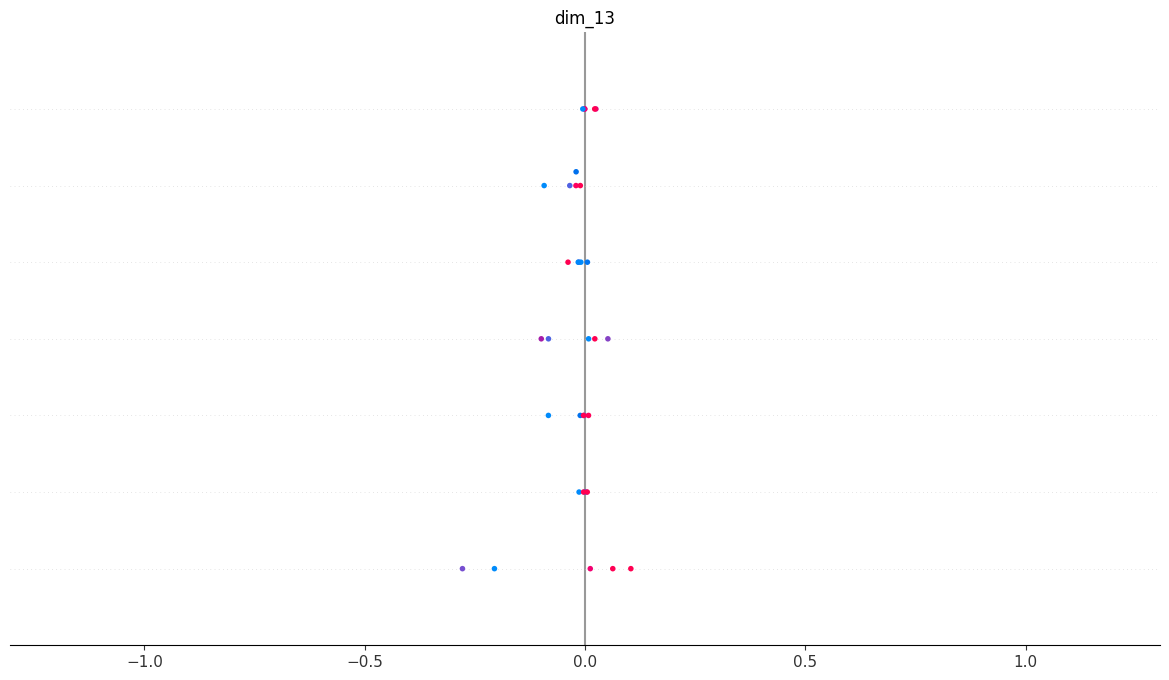

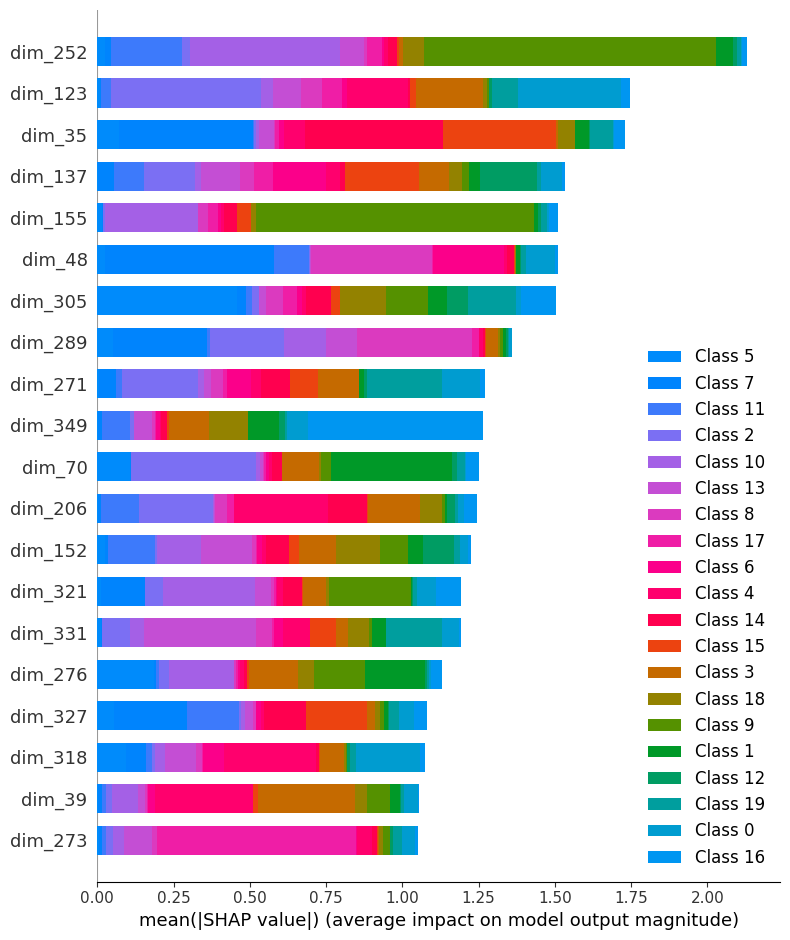

In [ ]:
#Prediction explanation using SHAP
#Setup
# Feature names (for SBERT, just dummy dim_0, dim_1, ..., dim_383)
feature_names = [f"dim_{i}" for i in range(X_train_embeddings.shape[1])]

# Use TreeExplainer directly for XGBoost
explainer = shap.TreeExplainer(xgb_clf)

# Compute SHAP values (returns Explanation-like object)
shap_values = explainer.shap_values(X_test_embeddings[:5])

# Plot summary (multiple samples)
shap.summary_plot(shap_values, X_test_embeddings[:5], feature_names=feature_names)

# Plot bar (average feature importance across classes)
shap.summary_plot(shap_values, X_test_embeddings[:5], plot_type="bar", feature_names=feature_names)

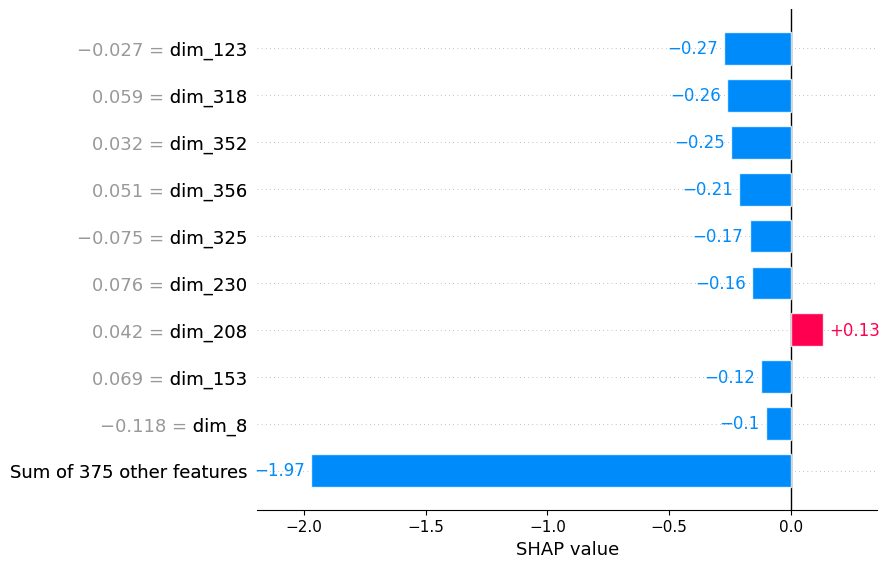

In [ ]:
shap_values_instance_class = shap_values[0, :, 0]
explanation_instance_class = shap.Explanation(
    values=shap_values_instance_class,
    base_values=explainer.expected_value[0], # Use the expected value for the first class
    data=X_test_embeddings[0, :], # Use the feature values for the first instance
    feature_names=feature_names # Pass the feature names here
)
shap.plots.bar(explanation_instance_class)